In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

# Time Series Generator

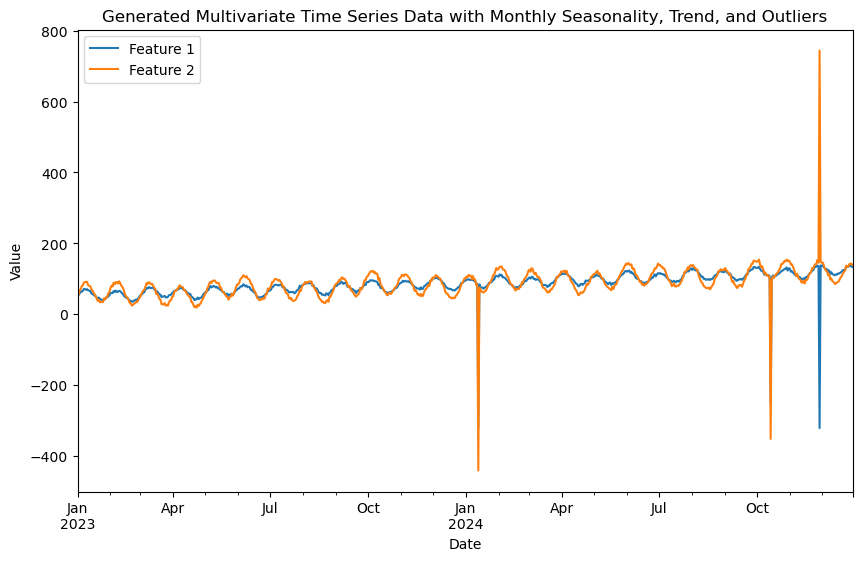

In [2]:
def generate_timeseries_data(start_date='2023-01-01', frequency='D', num_steps=200, trend=0, n_outliers=5, outlier_multiplier=10):
    # Set the seed
    np.random.seed(42)

    # Setting the time steps
    time_steps = np.arange(0, num_steps)

    # Introduce monthly seasonality by adjusting the frequency in the sine function.
    monthly_seasonality = np.sin(time_steps * (2 * np.pi / 30))
    
    # Generating the time series data with a trend
    feature_1 = 50 + trend * time_steps + 5 * np.sin(time_steps * 0.1) + 15 * monthly_seasonality + np.random.normal(0, 2, size=time_steps.shape)
    feature_2 = feature_1 + 10 * np.sin(time_steps * 0.05) + 15 * monthly_seasonality + np.random.normal(0, 2, size=time_steps.shape)

    # Introduce outliers
    outlier_indices = np.random.choice(num_steps, n_outliers, replace=False)
    for index in outlier_indices:
        feature_1[index] += np.random.choice([-1, 1]) * outlier_multiplier * np.std(feature_1)
        feature_2[index] += np.random.choice([-1, 1]) * outlier_multiplier * np.std(feature_2)

    # Creating a datetime index
    date_index = pd.date_range(start=start_date, periods=num_steps, freq=frequency)

    # Combining the two features into a DataFrame
    data = pd.DataFrame({
        'Feature 1': feature_1,
        'Feature 2': feature_2
    }, index=date_index)

    # Plotting the generated time series data
    plt.figure(figsize=(10, 6))
    data.plot(ax=plt.gca())
    plt.title('Generated Multivariate Time Series Data with Monthly Seasonality, Trend, and Outliers')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

    return data

# Usage
data = generate_timeseries_data('2023-01-01', 'D', 365*2, trend=0.1, n_outliers=3, outlier_multiplier=15)

# Outlier Removal

In [3]:
def remove_outliers(df, columns_to_clean, window=30, z_threshold=3.0, imputation_method='linear'):
    cleaned_df = df.copy()
    
    for column in columns_to_clean:
        # Calculate rolling mean and rolling standard deviation
        rolling_mean = cleaned_df[column].rolling(window=window, center=True).mean()
        rolling_std = cleaned_df[column].rolling(window=window, center=True).std()
        
        # Compute the z-scores
        z_scores = (cleaned_df[column] - rolling_mean) / rolling_std
        
        # Identify outliers
        outliers = z_scores.abs() > z_threshold
        
        # Impute outliers
        if imputation_method == 'linear':
            cleaned_df[column][outliers] = np.nan
            cleaned_df[column].interpolate(method='linear', inplace=True)
        elif imputation_method == 'rolling_mean':
            cleaned_df[column][outliers] = rolling_mean
        elif imputation_method == 'rolling_median':
            rolling_median = cleaned_df[column].rolling(window=window, center=True).median()
            cleaned_df[column][outliers] = rolling_median
        else:
            raise ValueError("Imputation method not recognized. Choose 'linear', 'rolling_mean', or 'rolling_median'.")
    
    return cleaned_df

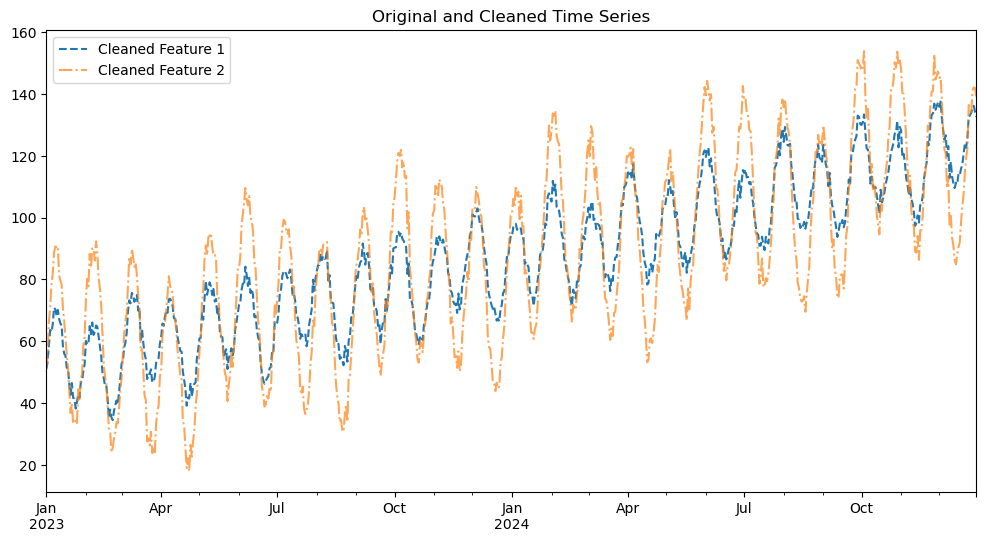

In [4]:
columns_to_clean = ['Feature 1', 'Feature 2']
cleaned_data = remove_outliers(data, columns_to_clean, window=30, z_threshold=3.0, imputation_method='linear')

# Plot the original and cleaned data for comparison
plt.figure(figsize=(12, 6))
cleaned_data['Feature 1'].plot(label='Cleaned Feature 1', linestyle='--')
cleaned_data['Feature 2'].plot(label='Cleaned Feature 2', linestyle='-.', alpha=0.7)
plt.legend()
plt.title("Original and Cleaned Time Series")
plt.show()

In [5]:
cleaned_data

,Feature 1,Feature 2
2023-01-01,50.993428,51.385119
2023-01-02,53.441314,55.103035
2023-01-03,58.589773,66.505663
2023-01-04,63.640440,70.546432
2023-01-05,63.025957,78.218134
...,...,...
2024-12-26,133.917546,133.460346
2024-12-27,135.219409,141.138956
2024-12-28,136.168066,142.092927
2024-12-29,134.053196,141.917327


In [6]:
original_data_cleaned = cleaned_data.copy()

In [7]:
data= cleaned_data.copy()

# Stationarity Test

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    # Perform the ADF test
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    
    # Print the results
    print('ADF Statistic:', result[0])
    print('p-value:', p_value)
    print('Critical Values:', result[4])
    
    if p_value <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

In [9]:
test_stationarity(data['Feature 1'])

ADF Statistic: -0.3107159193955043
p-value: 0.9239728657482025
Critical Values: {'1%': -3.439580754053961, '5%': -2.865613606467485, '10%': -2.568939269723711}
The time series is not stationary.


In [10]:
test_stationarity(data['Feature 2'])

ADF Statistic: -0.9057556988509955
p-value: 0.7860710743423573
Critical Values: {'1%': -3.4395677423210493, '5%': -2.8656078730509784, '10%': -2.5689362152032573}
The time series is not stationary.


# Time Series Decomposition

In [11]:
from statsmodels.tsa.seasonal import STL

def stl_decomposition(df, columns_to_decompose, period=None):
    decomposed_df = df.copy()
    
    for column in columns_to_decompose:
        # Decompose the series
        if period is None:
            period = max(2, (len(df) // 2) - 1)  # Default period setting if not provided
        
        stl = STL(df[column], period=period)
        result = stl.fit()
        
        # Store the decomposed components in the DataFrame
        decomposed_df[f"{column}_trend"] = result.trend
        decomposed_df[f"{column}_seasonal"] = result.seasonal
        decomposed_df[f"{column}_resid"] = result.resid
    
    return decomposed_df

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

def classic_decomposition_updated(df, columns_to_decompose, model='additive', period=None):
    decomposed_df = df.copy()
    
    for column in columns_to_decompose:
        # Decompose the series
        result = seasonal_decompose(df[column], model=model, period=period)
        
        # Store the decomposed components in the DataFrame
        decomposed_df[f"{column}_trend"] = result.trend
        decomposed_df[f"{column}_seasonal"] = result.seasonal
        decomposed_df[f"{column}_resid"] = result.resid
    
    return decomposed_df

In [13]:
columns_to_decompose = ['Feature 1', 'Feature 2']
decomposed_data = stl_decomposition(data, columns_to_decompose, period=30)  # Assuming monthly seasonality
# decomposed_data = classic_decomposition_updated(data, columns_to_decompose, model='additive', period=30)

In [14]:
decomposed_data

,Feature 1,Feature 2,Feature 1_trend,Feature 1_seasonal,Feature 1_resid,Feature 2_trend,Feature 2_seasonal,Feature 2_resid
2023-01-01,50.993428,51.385119,55.530364,-3.051438,-1.485498,57.965200,-4.646743,-1.933338
2023-01-02,53.441314,55.103035,55.459615,1.907551,-3.925852,58.139784,2.661812,-5.698560
2023-01-03,58.589773,66.505663,55.386984,4.215169,-1.012380,58.310758,11.725041,-3.530137
2023-01-04,63.640440,70.546432,55.312456,7.975329,0.352655,58.478026,12.847246,-0.778840
2023-01-05,63.025957,78.218134,55.236038,10.134926,-2.345007,58.641543,21.935689,-2.359098
...,...,...,...,...,...,...,...,...
2024-12-26,133.917546,133.460346,124.219743,11.010007,-1.312203,114.021793,20.217814,-0.779262
2024-12-27,135.219409,141.138956,124.278955,12.868852,-1.928398,113.830537,29.347447,-2.039028
2024-12-28,136.168066,142.092927,124.335018,13.135952,-1.302903,113.638510,27.612611,0.841805
2024-12-29,134.053196,141.917327,124.388029,11.222617,-1.557450,113.445784,27.793850,0.677693


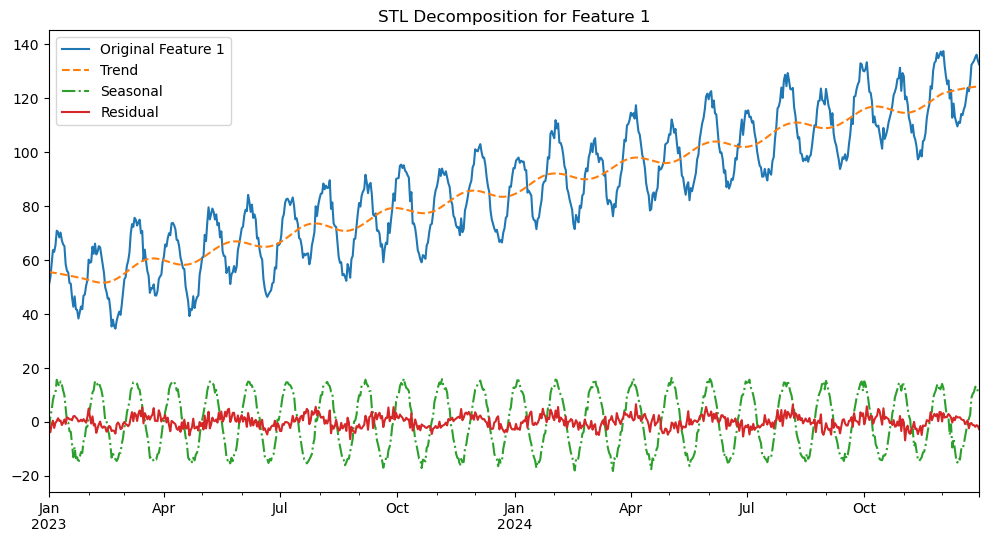

In [15]:
# Plot the original, trend, seasonal, and residual components for Feature 1
plt.figure(figsize=(12, 6))
decomposed_data['Feature 1'].plot(label='Original Feature 1')
decomposed_data['Feature 1_trend'].plot(label='Trend', linestyle='--')
decomposed_data['Feature 1_seasonal'].plot(label='Seasonal', linestyle='-.')
decomposed_data['Feature 1_resid'].plot(label='Residual', linestyle='-')
plt.legend()
plt.title("STL Decomposition for Feature 1")
plt.show()

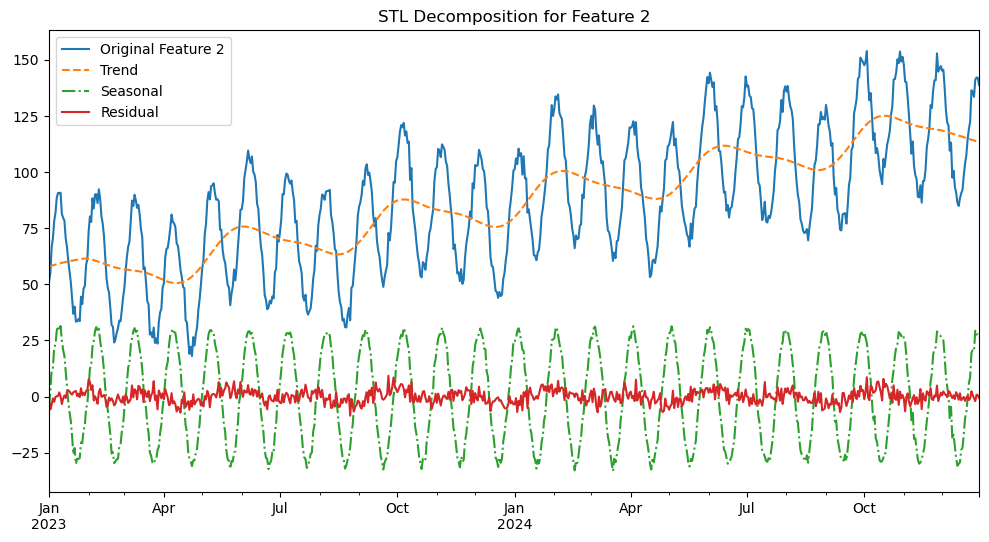

In [16]:
# Plot the original, trend, seasonal, and residual components for Feature 1
plt.figure(figsize=(12, 6))
decomposed_data['Feature 2'].plot(label='Original Feature 2')
decomposed_data['Feature 2_trend'].plot(label='Trend', linestyle='--')
decomposed_data['Feature 2_seasonal'].plot(label='Seasonal', linestyle='-.')
decomposed_data['Feature 2_resid'].plot(label='Residual', linestyle='-')
plt.legend()
plt.title("STL Decomposition for Feature 2")
plt.show()

In [17]:
decomposed_data

,Feature 1,Feature 2,Feature 1_trend,Feature 1_seasonal,Feature 1_resid,Feature 2_trend,Feature 2_seasonal,Feature 2_resid
2023-01-01,50.993428,51.385119,55.530364,-3.051438,-1.485498,57.965200,-4.646743,-1.933338
2023-01-02,53.441314,55.103035,55.459615,1.907551,-3.925852,58.139784,2.661812,-5.698560
2023-01-03,58.589773,66.505663,55.386984,4.215169,-1.012380,58.310758,11.725041,-3.530137
2023-01-04,63.640440,70.546432,55.312456,7.975329,0.352655,58.478026,12.847246,-0.778840
2023-01-05,63.025957,78.218134,55.236038,10.134926,-2.345007,58.641543,21.935689,-2.359098
...,...,...,...,...,...,...,...,...
2024-12-26,133.917546,133.460346,124.219743,11.010007,-1.312203,114.021793,20.217814,-0.779262
2024-12-27,135.219409,141.138956,124.278955,12.868852,-1.928398,113.830537,29.347447,-2.039028
2024-12-28,136.168066,142.092927,124.335018,13.135952,-1.302903,113.638510,27.612611,0.841805
2024-12-29,134.053196,141.917327,124.388029,11.222617,-1.557450,113.445784,27.793850,0.677693


In [18]:
data = decomposed_data

In [19]:
test_stationarity(data['Feature 1'])

ADF Statistic: -0.3107159193955043
p-value: 0.9239728657482025
Critical Values: {'1%': -3.439580754053961, '5%': -2.865613606467485, '10%': -2.568939269723711}
The time series is not stationary.


In [20]:
test_stationarity(data['Feature 2'])

ADF Statistic: -0.9057556988509955
p-value: 0.7860710743423573
Critical Values: {'1%': -3.4395677423210493, '5%': -2.8656078730509784, '10%': -2.5689362152032573}
The time series is not stationary.


Once you have decomposed your time series, you can effectively leverage the components to improve your forecasting with ARIMA. Here's a structured approach:

1. **Component-wise Forecasting**:
    - Instead of forecasting the original time series directly, you can forecast each of its decomposed components separately. This can simplify the forecasting process, especially if different components have distinct patterns.
    
    - **Trend**: If your decomposition reveals a trend component, you can model this trend using ARIMA or even simpler models (like linear regression) if the trend is linear. 
    - **Seasonal**: For the seasonal component, ensure that the ARIMA model's seasonal parameters are set to capture the periodic patterns. 
    - **Residual**: The residual component, being the "noise" or irregular component after removing trend and seasonality, should ideally be white noise. However, if there's some autocorrelation left, you can model this with ARIMA too.

2. **Recomposition for Prediction**:
    - After forecasting each component separately for a desired number of future time points, you'll have forecasts for the trend, seasonal, and residual components.
    - Combine these forecasts to obtain the forecast for the original series. If you used an additive decomposition, simply add the forecasts of the components. If it was multiplicative, multiply them.

3. **Model Validation**:
    - Before making final predictions, validate your model(s). This typically involves:
        - **Checking Residuals**: Residuals of your ARIMA model should ideally resemble white noise. Use ACF and PACF plots to check this.
        - **Out-of-sample Testing**: Split your data into a training set and a test set. Fit the model to the training set, forecast for the length of the test set, and compare the forecasts to the actual test set values. This will give you an idea of the model's accuracy.
        - **Information Criteria**: Use criteria like AIC or BIC to compare different ARIMA models and choose the best one.

4. **Hyperparameter Tuning**:
    - ARIMA models come with various hyperparameters (p,d,q)(P,D,Q)s. You can use tools like `auto_arima` from `pmdarima` to automatically select the best parameters. Remember to set the seasonal order (P,D,Q,s) if you're modeling the seasonal component with ARIMA.

5. **Consider External Factors**:
    - If you believe external factors (like holidays, events, etc.) significantly affect your series, consider SARIMAX (Seasonal ARIMA with eXogenous variables) instead of plain ARIMA. It allows the inclusion of external variables in the modeling process.

6. **Final Forecasting**:
    - Once you've selected and validated the best model, fit it to the entire dataset and forecast the desired number of future time points.

7. **Confidence Intervals**:
    - ARIMA models can also provide confidence intervals for their forecasts, which give a range in which the actual value is likely to fall. This is useful for understanding the uncertainty associated with predictions.

Remember, while ARIMA is a powerful and widely-used method, it's not the only forecasting model out there. Depending on the nature of your data and the business problem, other models like Prophet, state space models, or even machine learning models might be more appropriate. Always consider the context and the specific characteristics of your data when choosing a forecasting approach.

# Trend Forecast with Linear Model

In [21]:
from sklearn.linear_model import LinearRegression

def forecast_trend_with_linear_regression(trend_series, n_forecast_steps):
    # Prepare the data
    X = np.array(range(len(trend_series))).reshape(-1, 1)
    y = trend_series.values
    
    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    
    # Forecast the next values
    X_forecast = np.array(range(len(trend_series), len(trend_series) + n_forecast_steps)).reshape(-1, 1)
    forecast_values = model.predict(X_forecast)
    
    # Create a pandas Series with forecasted values and timestamps
    forecast_dates = pd.date_range(trend_series.index[-1], periods=n_forecast_steps+1, closed='right')
    forecast_series = pd.Series(forecast_values, index=forecast_dates)
    
    return forecast_series

In [22]:
# Test the function using the trend component of Feature 1
trend_series = decomposed_data['Feature 1_trend'].dropna()
forecasted_trend_series = forecast_trend_with_linear_regression(trend_series, 30)  # Forecast next 30 steps
forecasted_trend_series

C:\Users\usuario\AppData\Local\Temp\ipykernel_11636\649856801.py:17: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(trend_series.index[-1], periods=n_forecast_steps+1, closed='right')


2024-12-31    122.982806
2025-01-01    123.082407
2025-01-02    123.182007
2025-01-03    123.281608
2025-01-04    123.381208
2025-01-05    123.480809
2025-01-06    123.580409
2025-01-07    123.680010
2025-01-08    123.779610
2025-01-09    123.879211
2025-01-10    123.978811
2025-01-11    124.078412
2025-01-12    124.178012
2025-01-13    124.277613
2025-01-14    124.377213
2025-01-15    124.476814
2025-01-16    124.576414
2025-01-17    124.676014
2025-01-18    124.775615
2025-01-19    124.875215
2025-01-20    124.974816
2025-01-21    125.074416
2025-01-22    125.174017
2025-01-23    125.273617
2025-01-24    125.373218
2025-01-25    125.472818
2025-01-26    125.572419
2025-01-27    125.672019
2025-01-28    125.771620
2025-01-29    125.871220
Freq: D, dtype: float64

# Seasonal Forecast with ARIMA

In [23]:
# ! pip install pmdarima

In [24]:
# Forecasting and plotting for each feature
n_forecast_steps = 30  # For example

In [25]:
def forecast_with_auto_arima(series, n_forecast_steps, forecast_type='future'):
    # Determine the data to fit based on the forecast type
    if forecast_type == 'overlap':
        fit_series = series[:-n_forecast_steps]
    else:
        fit_series = series
        
    # Fit the best ARIMA model using auto_arima
    model = pm.auto_arima(fit_series, seasonal=True, m=12, trace=True,
#                           start_p=0, d=1, start_q=0,
#                           max_p=5, max_d=5, max_q=5,
#                           start_P=0, D=1, start_Q=0,
#                           max_P=5, max_D=5, max_Q=5,
                          error_action='ignore', suppress_warnings=True,
                          n_fits=50)
    
    # Forecast the future values
    forecast, conf_int = model.predict(n_periods=n_forecast_steps, return_conf_int=True)
    
    return forecast, conf_int

def plot_forecast(original_series, forecast, conf_int, title, forecast_type='future'):
    # Plotting original series
    plt.figure(figsize=(12, 6))
    plt.plot(original_series, label='Original Data')
    
    # Determine the range for forecast dates based on the forecast type
    if forecast_type == 'future':
        forecast_dates = pd.date_range(original_series.index[-1], periods=len(forecast)+1, closed='right')
    else:
        forecast_dates = original_series.index[-len(forecast):]
    
    # Plotting the forecast
    plt.plot(forecast_dates, forecast, color='red', label='Forecast')
    
    # Plotting the confidence intervals
    plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=5513.041, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3274.936, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4294.704, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5511.125, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3505.043, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=3270.122, Time=1.68 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=3265.126, Time=2.22 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=3263.620, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=3286.076, Time=0.08 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.87 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=3

C:\Users\usuario\AppData\Local\Temp\ipykernel_11636\2534656493.py:29: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(original_series.index[-1], periods=len(forecast)+1, closed='right')


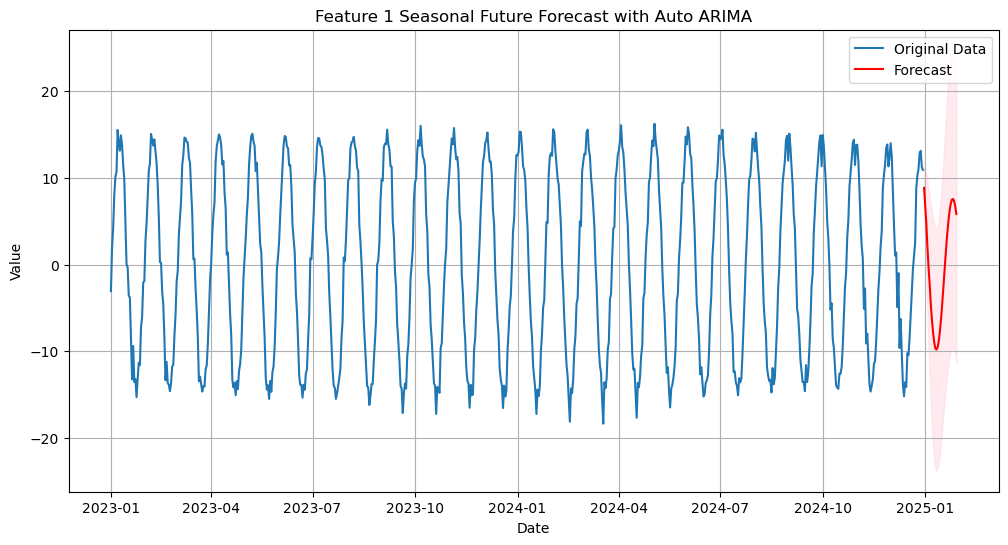

In [26]:
seas_forecast_1, seas_conf_int_1 = forecast_with_auto_arima(data['Feature 1_seasonal'], n_forecast_steps, forecast_type='future')
plot_forecast(data['Feature 1_seasonal'], seas_forecast_1, seas_conf_int_1, 'Feature 1 Seasonal Future Forecast with Auto ARIMA', forecast_type='future')

# Residual Forecast with ARIMA

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3258.099, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=3038.264, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3116.634, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3256.116, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=3036.441, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=3038.210, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=3037.980, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=2966.989, Time=0.04 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=2968.965, Time=0.21 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=2968.959, Time=0.14 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AIC=2925.595, Time=0.07 sec
 ARIMA(3,0,0)(1,0,0)[12] intercept   : AIC=2927.595, Time=0.27 sec
 ARIMA(3,0,0)(0,0,1)[12] inte

C:\Users\usuario\AppData\Local\Temp\ipykernel_11636\2534656493.py:29: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(original_series.index[-1], periods=len(forecast)+1, closed='right')


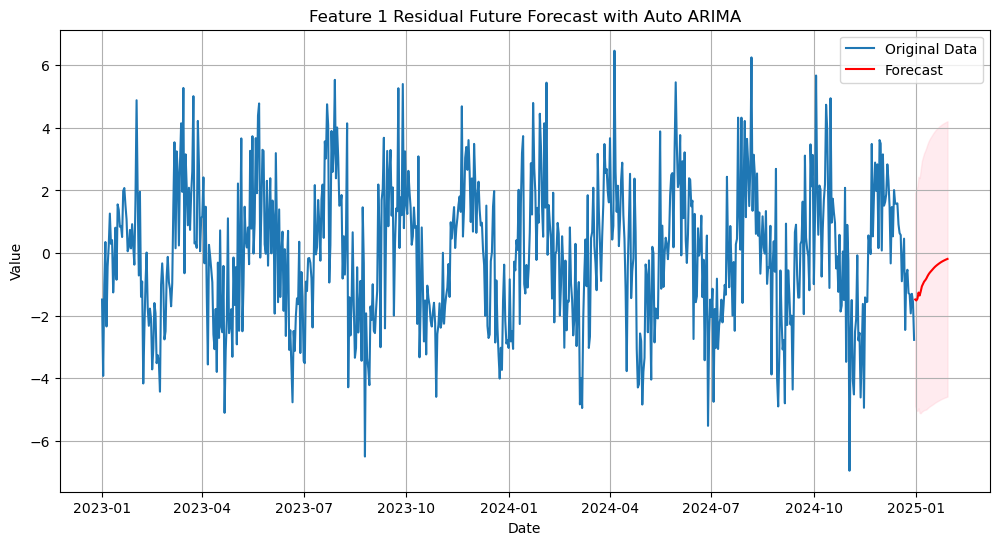

In [27]:
forecast_1, conf_int_1 = forecast_with_auto_arima(data['Feature 1_resid'], n_forecast_steps, forecast_type='future')
plot_forecast(data['Feature 1_resid'], forecast_1, conf_int_1, 'Feature 1 Residual Future Forecast with Auto ARIMA', forecast_type='future')

In [28]:
# forecast_1, conf_int_1 = forecast_with_auto_arima(data['Feature 1_resid'], n_forecast_steps, forecast_type='overlap')
# plot_forecast(data['Feature 1_resid'], forecast_1, conf_int_1, 'Feature 1 Residual Overlapping Forecast with Auto ARIMA', forecast_type='overlap')

# Combine the Component Forecasts

In [29]:
def combine_forecasts(trend_forecast, seasonal_forecast, residual_forecast, method='additive'):
    """
    Combine the component forecasts to get the full time series forecast.
    
    Args:
    - trend_forecast: Forecasted values of the trend component.
    - seasonal_forecast: Forecasted values of the seasonal component.
    - residual_forecast: Forecasted values of the residual component.
    - method: 'additive' or 'multiplicative' decomposition method.
    
    Returns:
    - Combined forecast.
    """
    
    if method == 'additive':
        return trend_forecast + seasonal_forecast + residual_forecast
    elif method == 'STL':
        return trend_forecast + seasonal_forecast + residual_forecast
    elif method == 'multiplicative':
        return trend_forecast * seasonal_forecast * residual_forecast
    else:
        raise ValueError("Method must be either 'additive' or 'multiplicative'.")

def plot_combined_forecast(original_series, combined_forecast, title):
    """
    Plot the original series and the combined forecast.
    
    Args:
    - original_series: Original time series data.
    - combined_forecast: Forecasted values.
    - title: Plot title.
    """
    
    # Plotting original series
    plt.figure(figsize=(12, 6))
    plt.plot(original_series, label='Original Data')
    
    # Plotting the forecast
    forecast_dates = pd.date_range(original_series.index[-1], periods=len(combined_forecast)+1, closed='right')
    plt.plot(forecast_dates, combined_forecast, color='red', label='Combined Forecast')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Here's how you'd use the functions:

# First, you'll need to get forecasts for the trend and residual components, similar to how you got the seasonal forecast.
# trend_forecast, _ = forecast_with_auto_arima(decomposed_data['Feature 1_trend'], n_forecast_steps, forecast_type='future')
# resid_forecast, _ = forecast_with_auto_arima(decomposed_data['Feature 1_resid'], n_forecast_steps, forecast_type='future')

# Then, you'd combine the forecasts:
# combined_forecast = combine_forecasts(trend_forecast, seas_forecast_1, resid_forecast, method='additive')

# And plot:
# plot_combined_forecast(data['Feature 1'], combined_forecast, 'Combined Forecast for Feature 1')

# Note: Since the forecasting and decomposition functions are provided in the prompt, 
# the code above is commented out to avoid execution errors.


In [30]:
forecasted_trend_series

2024-12-31    122.982806
2025-01-01    123.082407
2025-01-02    123.182007
2025-01-03    123.281608
2025-01-04    123.381208
2025-01-05    123.480809
2025-01-06    123.580409
2025-01-07    123.680010
2025-01-08    123.779610
2025-01-09    123.879211
2025-01-10    123.978811
2025-01-11    124.078412
2025-01-12    124.178012
2025-01-13    124.277613
2025-01-14    124.377213
2025-01-15    124.476814
2025-01-16    124.576414
2025-01-17    124.676014
2025-01-18    124.775615
2025-01-19    124.875215
2025-01-20    124.974816
2025-01-21    125.074416
2025-01-22    125.174017
2025-01-23    125.273617
2025-01-24    125.373218
2025-01-25    125.472818
2025-01-26    125.572419
2025-01-27    125.672019
2025-01-28    125.771620
2025-01-29    125.871220
Freq: D, dtype: float64

In [31]:
seas_forecast_1

2024-12-31    8.862415
2025-01-01    6.780050
2025-01-02    4.836540
2025-01-03    2.073034
2025-01-04   -0.279680
2025-01-05   -2.232518
2025-01-06   -4.478071
2025-01-07   -6.293603
2025-01-08   -7.745144
2025-01-09   -8.845335
2025-01-10   -9.610643
2025-01-11   -9.793831
2025-01-12   -9.604592
2025-01-13   -8.971463
2025-01-14   -7.933995
2025-01-15   -6.615351
2025-01-16   -5.020098
2025-01-17   -3.224220
2025-01-18   -1.380150
2025-01-19    0.471435
2025-01-20    2.243595
2025-01-21    3.849510
2025-01-22    5.218012
2025-01-23    6.316675
2025-01-24    7.086149
2025-01-25    7.512052
2025-01-26    7.587229
2025-01-27    7.314290
2025-01-28    6.723516
2025-01-29    5.852405
Freq: D, dtype: float64

In [32]:
forecast_1

2024-12-31   -1.482778
2025-01-01   -1.516796
2025-01-02   -1.460131
2025-01-03   -1.261487
2025-01-04   -1.356984
2025-01-05   -1.218925
2025-01-06   -1.063548
2025-01-07   -0.987625
2025-01-08   -0.912770
2025-01-09   -0.869009
2025-01-10   -0.815032
2025-01-11   -0.742861
2025-01-12   -0.680739
2025-01-13   -0.629951
2025-01-14   -0.587821
2025-01-15   -0.548457
2025-01-16   -0.507227
2025-01-17   -0.467423
2025-01-18   -0.431986
2025-01-19   -0.400836
2025-01-20   -0.372441
2025-01-21   -0.345301
2025-01-22   -0.319396
2025-01-23   -0.295438
2025-01-24   -0.273679
2025-01-25   -0.253787
2025-01-26   -0.235271
2025-01-27   -0.217903
2025-01-28   -0.201735
2025-01-29   -0.186832
Freq: D, dtype: float64

In [33]:
combined_forecast = combine_forecasts(forecasted_trend_series, seas_forecast_1, forecast_1, method='STL')

In [34]:
combined_forecast

2024-12-31    130.362444
2025-01-01    128.345660
2025-01-02    126.558415
2025-01-03    124.093155
2025-01-04    121.744545
2025-01-05    120.029365
2025-01-06    118.038790
2025-01-07    116.398782
2025-01-08    115.121696
2025-01-09    114.164866
2025-01-10    113.553137
2025-01-11    113.541719
2025-01-12    113.892681
2025-01-13    114.676199
2025-01-14    115.855397
2025-01-15    117.313006
2025-01-16    119.049089
2025-01-17    120.984372
2025-01-18    122.963479
2025-01-19    124.945814
2025-01-20    126.845970
2025-01-21    128.578625
2025-01-22    130.072633
2025-01-23    131.294854
2025-01-24    132.185688
2025-01-25    132.731083
2025-01-26    132.924376
2025-01-27    132.768406
2025-01-28    132.293400
2025-01-29    131.536793
Freq: D, dtype: float64

In [35]:
def combine_and_plot_original_forecast_v3(original_data, combined_forecast, feature_name):
    """
    Combine the original data with the combined forecast and plot them.
    
    Args:
    - original_data: Original DataFrame with historical data.
    - combined_forecast: Forecasted series to be appended.
    - feature_name: Name of the feature in the original data to which the forecast corresponds.
    
    Returns:
    - A DataFrame containing both the original data and the forecast.
    """
    
    # Combine original data and forecast
    combined_data = original_data.copy()
    combined_data = combined_data.reindex(combined_data.index.union(combined_forecast.index))
    
    # Assign the forecasted values to the combined data
    combined_data.loc[combined_forecast.index, feature_name] = combined_forecast.values
    
    # Plotting
    plt.figure(figsize=(12, 6))
    combined_data[feature_name].plot(ax=plt.gca(), label='Data + Forecast')
    original_data[feature_name].plot(ax=plt.gca(), label='Original Data', linestyle='--')
    plt.title(f'{feature_name} with Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return combined_data

In [36]:
original_data_cleaned

,Feature 1,Feature 2
2023-01-01,50.993428,51.385119
2023-01-02,53.441314,55.103035
2023-01-03,58.589773,66.505663
2023-01-04,63.640440,70.546432
2023-01-05,63.025957,78.218134
...,...,...
2024-12-26,133.917546,133.460346
2024-12-27,135.219409,141.138956
2024-12-28,136.168066,142.092927
2024-12-29,134.053196,141.917327


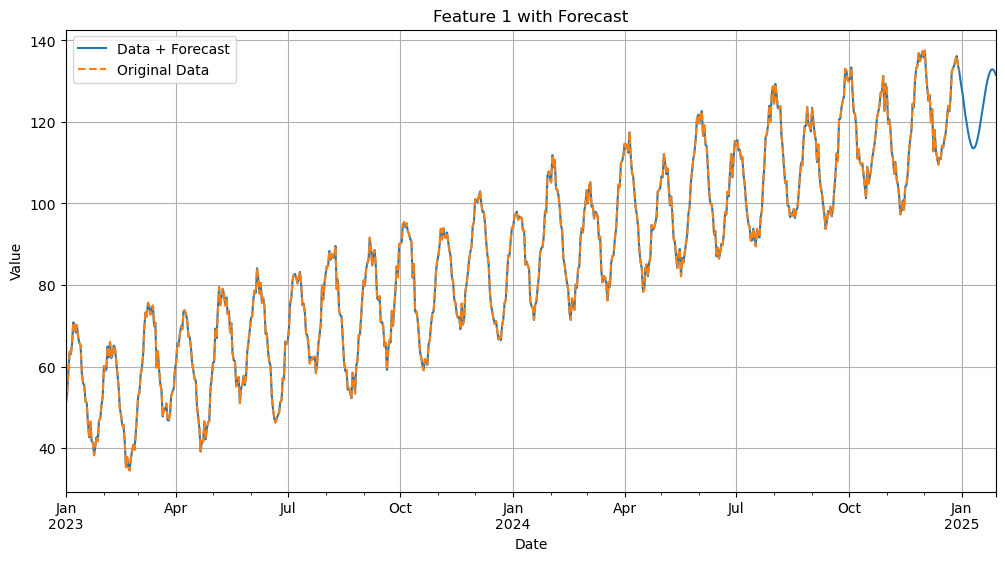

In [37]:
combined_data = combine_and_plot_original_forecast_v3(original_data_cleaned, combined_forecast, 'Feature 1')

In [38]:
combined_data

,Feature 1,Feature 2
2023-01-01,50.993428,51.385119
2023-01-02,53.441314,55.103035
2023-01-03,58.589773,66.505663
2023-01-04,63.640440,70.546432
2023-01-05,63.025957,78.218134
...,...,...
2025-01-25,132.731083,NaN
2025-01-26,132.924376,NaN
2025-01-27,132.768406,NaN
2025-01-28,132.293400,NaN


# TSMixer

In [55]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten, Reshape

# Define the TSMixer-inspired model
def build_tsmixer_model(input_shape, num_features):
    # Input layer
    input_layer = Input(shape=input_shape)
    
    # Time-mixing: A simple linear model for temporal patterns
    x = Flatten()(input_layer)
    x = Dense(units=input_shape[0] * num_features, activation='linear')(x)
    x = Reshape(target_shape=(input_shape[0], num_features))(x)
    
    # Feature-mixing: A basic MLP to capture cross-variate patterns
    x = Flatten()(x)
    x = Dense(units=50, activation='relu')(x)
    output_layer = Dense(units=num_features, activation='linear')(x)
    
    # Construct the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Create the TSMixer-inspired model
tsmixer_model = build_tsmixer_model(input_shape=(10, 2), num_features=2)
tsmixer_model.compile(optimizer='adam', loss='mean_squared_error')
tsmixer_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 2)]           0         
                                                                 
 flatten_2 (Flatten)         (None, 20)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 reshape_1 (Reshape)         (None, 10, 2)             0         
                                                                 
 flatten_3 (Flatten)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                1050      
                                                                 
 dense_5 (Dense)             (None, 2)                 102 

The provided model seems to be inspired by the idea of mixing temporal and feature-wise patterns, which can be crucial for multivariate time series data. Let's break down the architecture:

1. **Input Layer**:
    - The model takes in sequences of shape `(10, 2)`, which means it accepts sequences of length 10 with 2 features at each timestep.
    
2. **Time-mixing Component**:
    - The sequences are first flattened to reshape the data.
    - A dense (fully connected) layer follows, which acts as a simple linear model. The output size of this layer is the product of the sequence length and the number of features, ensuring that the output has the same shape as the input. This means that for each input feature at each timestep, there's a corresponding output. This layer essentially "mixes" the temporal patterns across time.
    - The output is then reshaped back to the original sequence shape using the `Reshape` layer.
    
3. **Feature-mixing Component**:
    - The reshaped sequences are again flattened.
    - A dense layer with 50 units and ReLU activation follows. This acts as a MultiLayer Perceptron (MLP) hidden layer and is expected to capture cross-variate patterns or interactions between features.
    - The final dense layer with an output size equal to the number of features predicts the output for each feature. This layer "mixes" the features, capturing interactions between them.
    
4. **Output**:
    - The model outputs a sequence with the same length as the input but with values representing the predicted next timestep for each feature.

5. **Compilation**:
    - The model is compiled with the Adam optimizer and uses the mean squared error as its loss function. This is a standard configuration for regression tasks, indicating that the model is designed to predict continuous values for each feature at the next timestep.

In summary, this TSMixer-inspired model is designed to handle multivariate time series data. It uses a time-mixing component to capture temporal patterns and a feature-mixing component (an MLP) to capture interactions between features. The combination of these components should allow the model to make predictions based on both the temporal evolution of each feature and the relationships between features.

Let's delve deeper into the design philosophy behind the time-mixing and feature-mixing components:

### Time-mixing Component

1. **Flatten**:
   The time series data is first flattened. This operation transforms the 2D sequence (time steps x features) into a 1D sequence. This step essentially linearizes the time dimension.

2. **Dense Layer (Linear Activation)**:
   This layer performs a linear transformation of the flattened data. Since each unit in this layer is connected to every time step of every feature in the input, it can potentially learn weights that mix or emphasize certain time steps over others. The linear activation ensures that the learned patterns are based on the linear combinations of the original time steps.

3. **Reshape**:
   After the linear transformation, the data is reshaped back to its original 2D format (time steps x features). This means that, after the transformation, we still maintain the temporal structure of the data.

The entire process described above is effectively a linear mixing of the time dimension across all features. It's designed to emphasize or de-emphasize certain time steps based on their importance for prediction.

### Feature-mixing Component

1. **Flatten**:
   After the time-mixing, the data is again flattened, preparing it for the multi-layer perceptron (MLP) that follows.

2. **Dense Layer (ReLU Activation)**:
   This layer is the hidden layer of the MLP. The ReLU activation introduces non-linearity, which allows the model to capture more complex relationships between the features. Given that every unit in this layer is connected to every feature from every time step in the input, it can learn weights that mix or emphasize certain features over others.

3. **Dense Layer (Linear Activation)**:
   The output layer of the MLP predicts the values for each feature at the next time step. It mixes the outputs from the previous layer, which are representations of the interactions between features.

The feature-mixing component, through its MLP structure, is designed to capture interactions between features. The non-linear transformation allows it to learn and represent more complex relationships between features than a purely linear model would.

---

In essence:

- The **time-mixing component** is about understanding the significance of each time step across features and adjusting the data accordingly. It tries to answer the question: "Which past time steps are most important for predicting the future?"
  
- The **feature-mixing component** is about understanding how different features interact with each other. It tries to answer the question: "How do different features influence each other when predicting the future?"

By combining both components, the model is designed to make predictions based on both the temporal patterns within each feature and the relationships between features.

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Scaling the data to range (0, 1)
scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data)

# Generate input-output pairs for supervised learning
def generate_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        Y.append(data[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 10
# X, Y = generate_dataset(scaled_data, look_back)
X, Y = generate_dataset(np.array(data[['Feature 1','Feature 2']]), look_back)

# # Splitting the data into training and testing sets (80% train, 20% test)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [57]:
np.array(data[['Feature 1','Feature 2']])

array([[ 50.99342831,  51.38511882],
       [ 53.44131384,  55.10303534],
       [ 58.58977338,  66.5056627 ],
       ...,
       [136.16806624, 142.09292683],
       [134.05319576, 141.91732746],
       [132.60976689, 138.73493544]])

In [58]:
def time_based_split(data, train_size=0.8):
    train_length = int(len(data) * train_size)
    train, test = data[:train_length], data[train_length:]
    return train, test

# Splitting the data into training and testing sets (80% train, 20% test based on time)
X_train, X_test = time_based_split(X, train_size=0.8)
Y_train, Y_test = time_based_split(Y, train_size=0.8)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((576, 10, 2), (144, 10, 2), (576, 2), (144, 2))

Epoch 1/50
72/72 [==============================] - 0s 2ms/step - loss: 603.6835 - val_loss: 89.0218
Epoch 2/50
72/72 [==============================] - 0s 1ms/step - loss: 64.1326 - val_loss: 41.8997
Epoch 3/50
72/72 [==============================] - 0s 1ms/step - loss: 40.4324 - val_loss: 36.8507
Epoch 4/50
72/72 [==============================] - 0s 1ms/step - loss: 35.6197 - val_loss: 33.1360
Epoch 5/50
72/72 [==============================] - 0s 995us/step - loss: 31.7189 - val_loss: 41.8715
Epoch 6/50
72/72 [==============================] - 0s 1ms/step - loss: 30.0327 - val_loss: 48.4880
Epoch 7/50
72/72 [==============================] - 0s 1ms/step - loss: 29.9027 - val_loss: 31.1980
Epoch 8/50
72/72 [==============================] - 0s 1ms/step - loss: 24.6980 - val_loss: 31.6391
Epoch 9/50
72/72 [==============================] - 0s 1ms/step - loss: 23.7107 - val_loss: 24.8231
Epoch 10/50
72/72 [==============================] - 0s 1ms/step - loss: 24.7284 - val_loss: 23.1

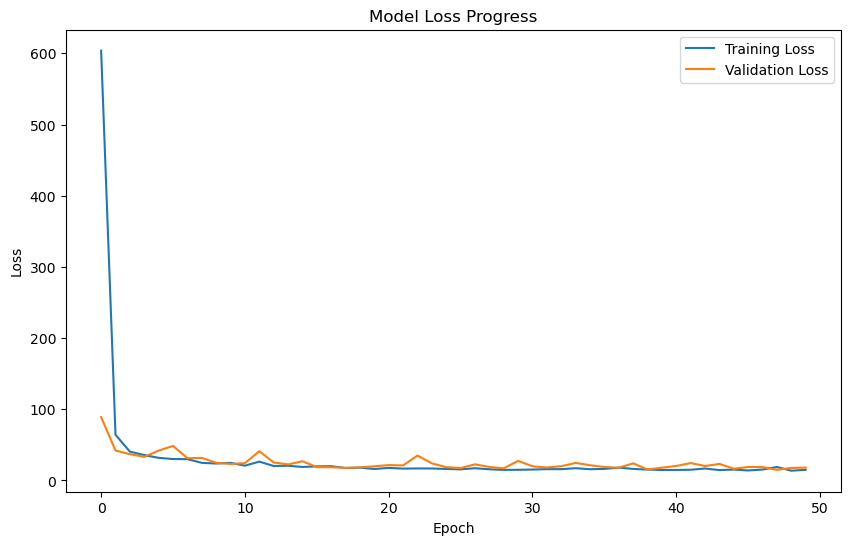

In [59]:
# Train the model
epochs = 50
batch_size = 8

history = tsmixer_model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_test, Y_test),
    verbose=1
)

# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

5/5 [==============================] - 0s 2ms/step


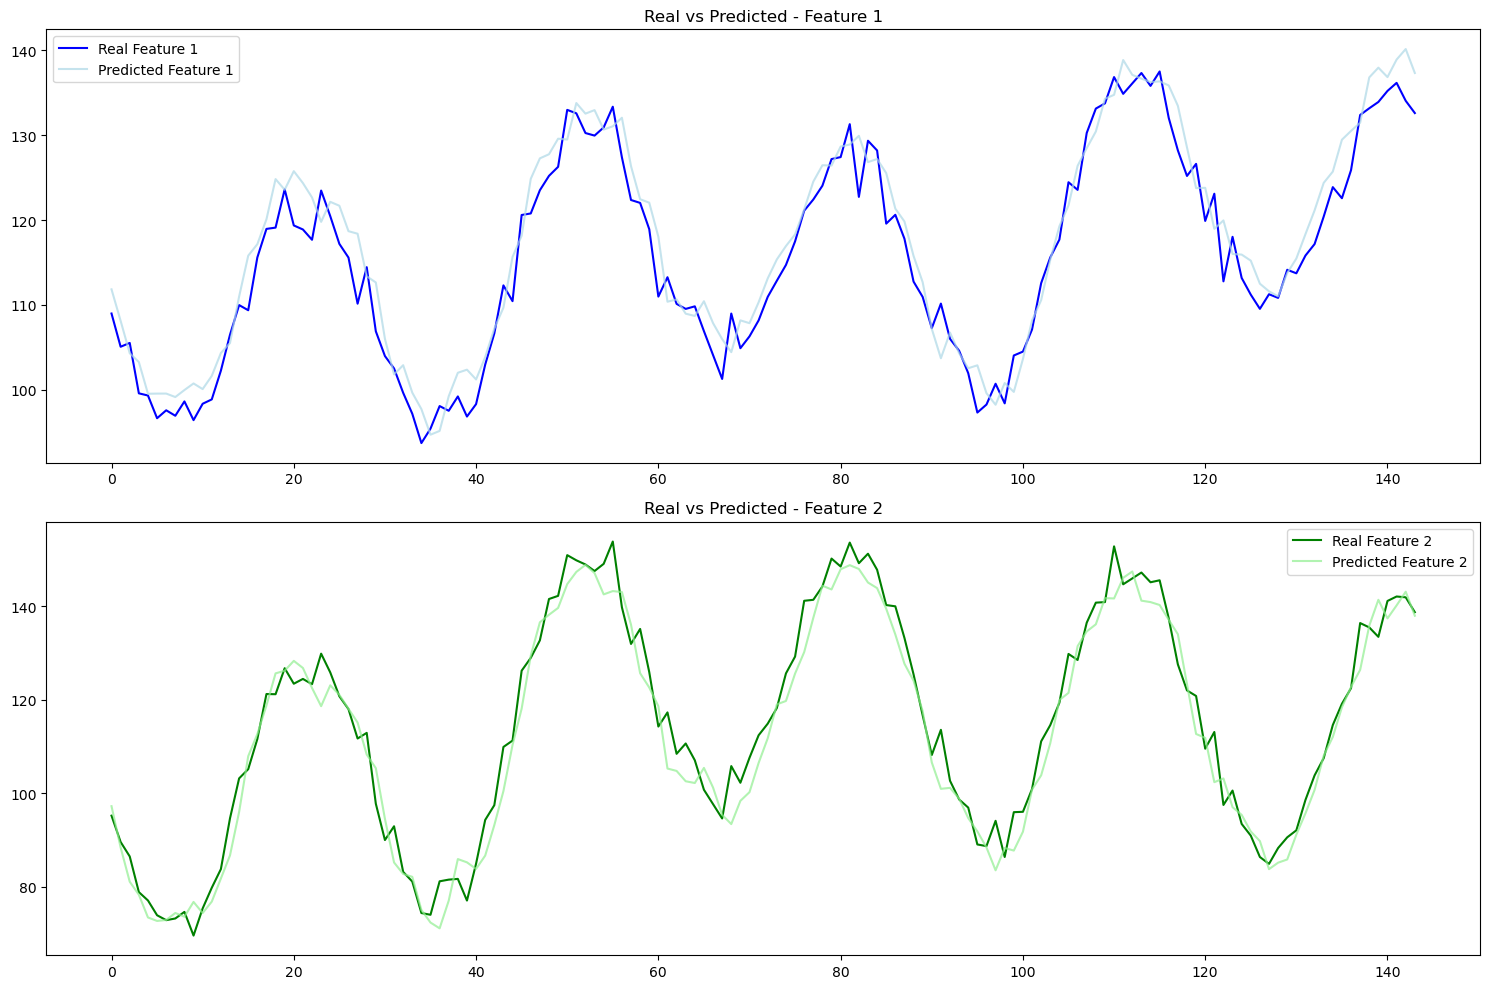

In [60]:
# Make predictions
predictions = tsmixer_model.predict(X_test)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plot Feature 1 (Real vs Predicted)
axes[0].plot(Y_test[:, 0], label='Real Feature 1', color='blue')
axes[0].plot(predictions[:, 0], label='Predicted Feature 1', alpha=0.7, color='lightblue')
axes[0].set_title('Real vs Predicted - Feature 1')
axes[0].legend()

# Plot Feature 2 (Real vs Predicted)
axes[1].plot(Y_test[:, 1], label='Real Feature 2', color='green')
axes[1].plot(predictions[:, 1], label='Predicted Feature 2', alpha=0.7, color='lightgreen')
axes[1].set_title('Real vs Predicted - Feature 2')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

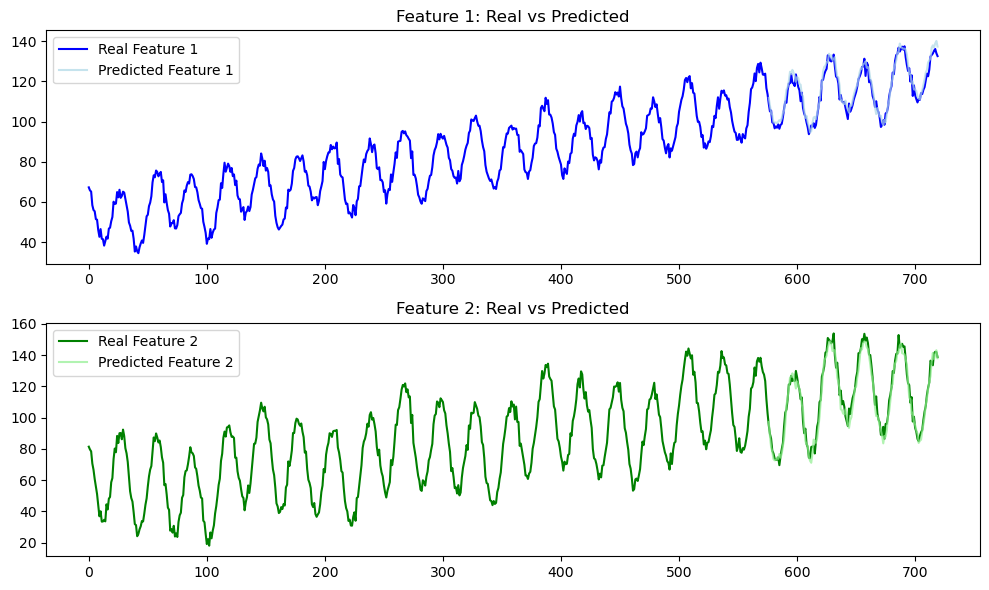

In [61]:
# Initialize empty arrays for the full sequence
full_true_sequence = np.empty((0, 2))
full_predicted_sequence = np.empty((0, 2))

# Add the Y_train data
full_true_sequence = np.vstack([full_true_sequence, Y_train])

# Add a gap (of NaN values) of the size of the test data in the predicted sequence
full_predicted_sequence = np.vstack([full_predicted_sequence, np.full((Y_train.shape[0], 2), np.nan)])

# Add the Y_test data to the true sequence
full_true_sequence = np.vstack([full_true_sequence, Y_test])

# Add the predicted values for the test data to the predicted sequence
full_predicted_sequence = np.vstack([full_predicted_sequence, predictions])

# Now, let's plot them side by side
plt.figure(figsize=(10,6))

# Plot for Feature 1
plt.subplot(2, 1, 1)
plt.plot(full_true_sequence[:, 0], label="Real Feature 1", color="blue")
plt.plot(full_predicted_sequence[:, 0], label="Predicted Feature 1", alpha=0.7, color="lightblue")
plt.title('Feature 1: Real vs Predicted')
plt.legend()

# Plot for Feature 2
plt.subplot(2, 1, 2)
plt.plot(full_true_sequence[:, 1], label="Real Feature 2", color="green")
plt.plot(full_predicted_sequence[:, 1], label="Predicted Feature 2", alpha=0.7, color="lightgreen")
plt.title('Feature 2: Real vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_1 = mean_absolute_error(Y_test[:, 0], predictions[:, 0])
mae_2 = mean_absolute_error(Y_test[:, 1], predictions[:, 1])

rmse_1 = np.sqrt(mean_squared_error(Y_test[:, 0], predictions[:, 0]))
rmse_2 = np.sqrt(mean_squared_error(Y_test[:, 1], predictions[:, 1]))

print(f"Feature 1 - MAE: {mae_1}, RMSE: {rmse_1}")
print(f"Feature 2 - MAE: {mae_2}, RMSE: {rmse_2}")

Feature 1 - MAE: 2.7108408989580575, RMSE: 3.256431192379323
Feature 2 - MAE: 3.8902460045404883, RMSE: 5.034014240785385


# Backtesting

Backtesting is a crucial step in model evaluation, especially for time series forecasting. The idea behind backtesting is to evaluate the model's performance on historical data by "pretending" that we don't have access to future data points and then making predictions for those data points.

Here's a basic way you can incorporate backtesting into your time series forecasting:

1. **Rolling Forecast Origin**: Instead of just training once and predicting the future, in backtesting, we'll use a rolling forecast origin. This means for each time point `t` in our test set, we'll:
    - Train the model using data up to `t`
    - Forecast the value at `t+1`
    - Store the predicted value and the real value
    - Move to the next time point

2. **Evaluation**: At the end of the backtesting, we'll have a series of predictions and real values. We can then compute various performance metrics (e.g., RMSE, MAE) to evaluate how well the model did.

In [ ]:
def backtest_model(model, X, Y, retrain=True):
    predictions = []
    true_values = []
    
    for t in range(len(X)):
        # Split data up to t
        X_train_bt = X[:t+1]
        Y_train_bt = Y[:t+1]
        
        # Retrain the model if needed
        if retrain:
            model.fit(X_train_bt, Y_train_bt, epochs=epochs, batch_size=batch_size, verbose=0)
        
        # Forecast the next value
        predicted_value = model.predict(X[t:t+1])
        true_value = Y[t]
        
        predictions.append(predicted_value[0])
        true_values.append(true_value)
    
    return np.array(predictions), np.array(true_values)

# Apply backtesting
predictions_bt, true_values_bt = backtest_model(tsmixer_model, X, Y, retrain=True)

# Evaluate results
mae_1_bt = mean_absolute_error(true_values_bt[:, 0], predictions_bt[:, 0])
mae_2_bt = mean_absolute_error(true_values_bt[:, 1], predictions_bt[:, 1])

rmse_1_bt = np.sqrt(mean_squared_error(true_values_bt[:, 0], predictions_bt[:, 0]))
rmse_2_bt = np.sqrt(mean_squared_error(true_values_bt[:, 1], predictions_bt[:, 1]))

print(f"[Backtest] Feature 1 - MAE: {mae_1_bt}, RMSE: {rmse_1_bt}")
print(f"[Backtest] Feature 2 - MAE: {mae_2_bt}, RMSE: {rmse_2_bt}")

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

# Plot Feature 1 (Real vs Predicted - Backtesting)
axes[0].plot(true_values_bt[:, 0], label='Real Feature 1', color='blue')
axes[0].plot(predictions_bt[:, 0], label='Backtest Predicted Feature 1', alpha=0.7, color='lightblue')
axes[0].set_title('Backtest Results - Feature 1')
axes[0].legend()

# Plot Feature 2 (Real vs Predicted - Backtesting)
axes[1].plot(true_values_bt[:, 1], label='Real Feature 2', color='green')
axes[1].plot(predictions_bt[:, 1], label='Backtest Predicted Feature 2', alpha=0.7, color='lightgreen')
axes[1].set_title('Backtest Results - Feature 2')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

# Forecast

In [ ]:
# Forecast the next 24 months
forecast_steps = 12
forecasted_data = []

# Initial input data: last 'look_back' points from the dataset
input_data = np.array(data[-look_back:])

for step in range(forecast_steps):
    # Predict the next step
    predicted_step = tsmixer_model.predict(input_data[-look_back:].reshape(1, look_back, 2))
    
    # Append the predicted step to the input data for the next iteration
    input_data = np.vstack([input_data, predicted_step])
    
    # Store the predicted step
    forecasted_data.append(predicted_step[0])

# Convert the forecasted data to a numpy array
forecasted_data = np.array(forecasted_data)

# Create a date range for the forecasted period
forecasted_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq="MS")

# Convert the forecasted data to a DataFrame for better visualization
forecasted_df = pd.DataFrame(forecasted_data, columns=['Forecasted_Feature_1', 'Forecasted_Feature_2'], index=forecasted_dates)

forecasted_df.tail()

In [ ]:
history_and_forecast_df = pd.concat([data[['Feature 1','Feature 2']], forecasted_df], axis=0)

In [ ]:
print(history_and_forecast_df)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Create two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot 'inflacion' and 'Forecasted_Inflation' on the first subplot
history_and_forecast_df[['inflacion', 'Forecasted_Inflation']].plot(ax=axes[0])
axes[0].set_title("Inflacion vs. Forecasted Inflation")
axes[0].set_ylabel("Value")
axes[0].grid(True)
axes[0].legend(loc='upper left')

# Plot 'leliqs' and 'Forecasted_LELIQs' on the second subplot
history_and_forecast_df[['leliqs', 'Forecasted_LELIQs']].plot(ax=axes[1])
axes[1].set_title("LELIQs vs. Forecasted LELIQs")
axes[1].set_ylabel("Value")
axes[1].grid(True)
axes[1].legend(loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()